# Autoencoder MNIST

## Importing required packages

In [120]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn 
import torch.nn.functional as F
from  torch.utils.data import DataLoader, SubsetRandomSampler
import torch.optim
from torchvision import datasets,transforms
from pytorch_lightning import seed_everything
import pandas as pd
import random

from sklearn.manifold import TSNE
from enum import auto
from sklearn.decomposition import PCA
import seaborn as sns

## Defining transforms

In [2]:
transforms=transforms.ToTensor()

## Downloading requried data

In [3]:
train_data=datasets.MNIST('data',train=True,download=True,transform=transforms)
test_data=datasets.MNIST('data',train=False,download=True,transform=transforms)

## Defining dataloaders

In [4]:
valid_size=0.2

# IMPORTANT 
batch_size=20

num_workers=0

train_length = len(train_data)

# obtain training dataset indices that will be used for validation dataset
indices = list(range(train_length))

np.random.shuffle(indices)
split = int(np.floor(valid_size * train_length))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders for train, test and validation dataset
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

In [5]:

# Printing the length of our train, valid and test dataloaders
# NOTE : Here batch size is 20
len(train_loader),len(valid_loader),len(test_loader)

(2400, 600, 500)

In [6]:
# Iterate over the data loader to get a batch of data
dataiter = iter(train_loader)

# Print the data iterator
print("Data Iterator:", dataiter)

# Get the next batch of images and labels
images, labels = next(dataiter)

# Print information about the images
print("Images:")
print(images)
print("Shape:", images.shape)
print("Number of Images:", len(images))
print("Shape of First Image:", images[0].shape)
print()

# Print information about the labels
print("Labels:")
print(labels)
print("Shape:", labels.shape)
print("Number of Labels:", len(labels))


Data Iterator: <torch.utils.data.dataloader._SingleProcessDataLoaderIter object at 0x7f0da8ce4fe0>
Images:
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0., 

## Visualizing a Training batch

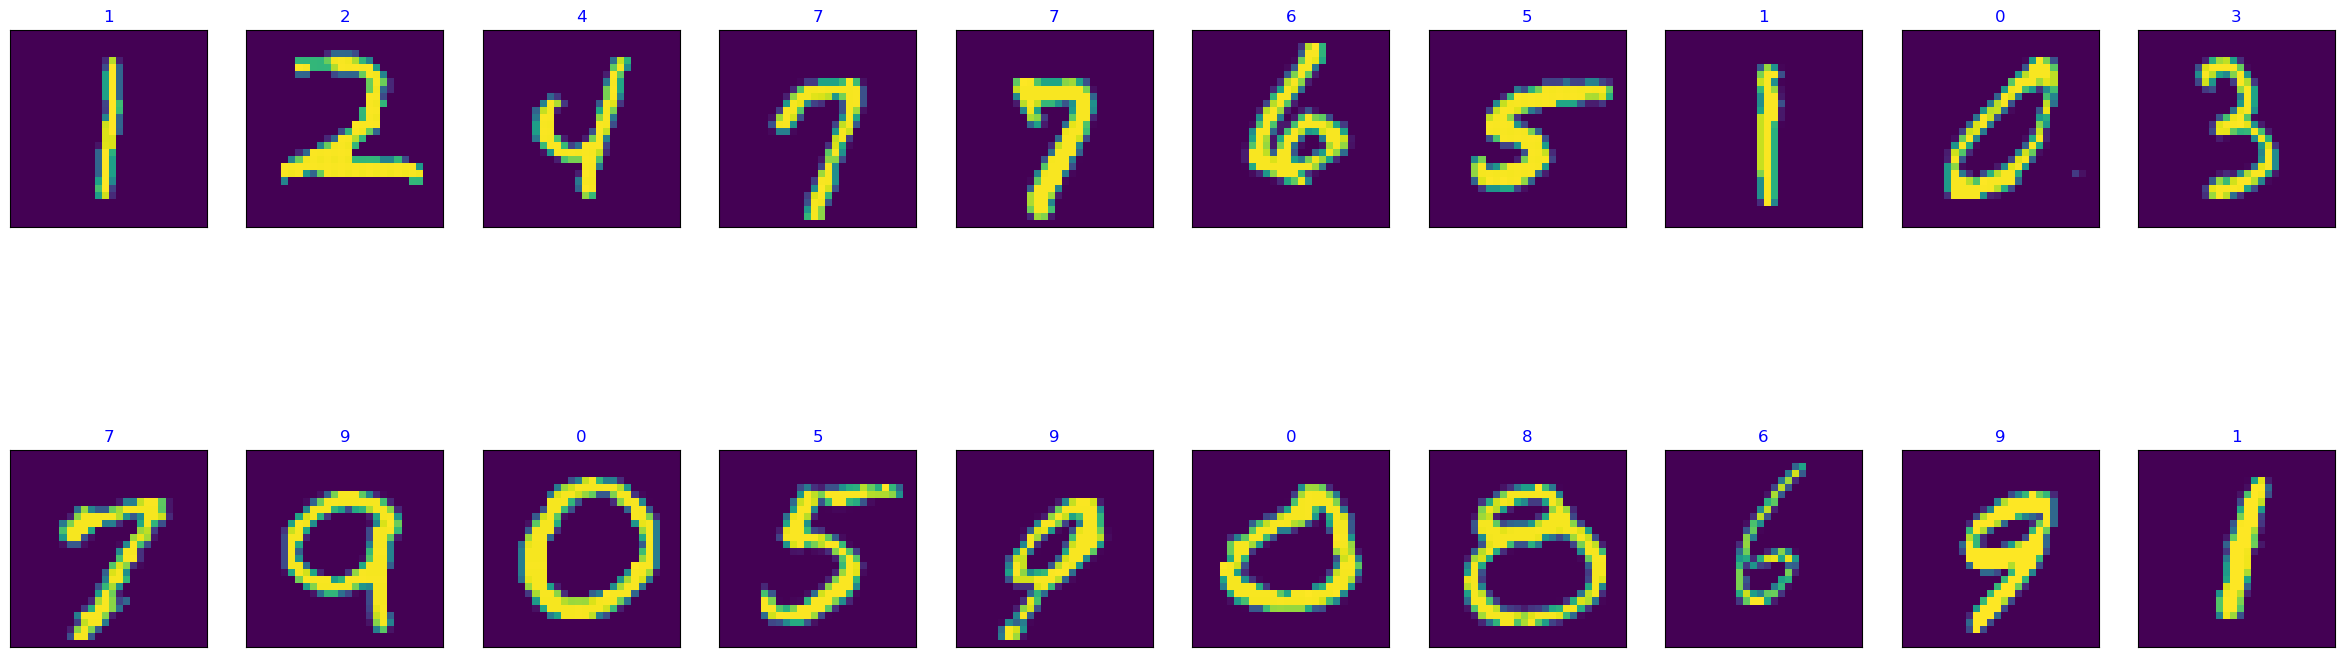

In [7]:
# Displaying images and labels of a batch
fig=plt.figure(figsize=(30,10))
for i in range(len(labels)):
    ax=fig.add_subplot(2,10,i+1,xticks=[],yticks=[])
    plt.imshow(np.squeeze(images[i]))
    ax.set_title(labels[i].item(),color='blue')

# Encoder/Decoder Seperation

In [8]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.conv1=nn.Conv2d(1,16,3,padding=1)
        self.conv2=nn.Conv2d(16,4,3,padding=1)
        self.pool=nn.MaxPool2d(2,2)
        
    def forward(self,x):
        x=F.relu(self.conv1(x))
        x=self.pool(x)
        x=F.relu(self.conv2(x))
        x=self.pool(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.t_conv1=nn.ConvTranspose2d(4,16,2,stride=2)
        self.t_conv2=nn.ConvTranspose2d(16,1,2,stride=2)
        
    def forward(self,x):
        x=F.relu(self.t_conv1(x))
        x=F.sigmoid(self.t_conv2(x))
        return x
    

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder,self).__init__()
        self.encoder=Encoder()
        self.decoder=Decoder()
        
    def forward(self,x):
        x=self.encoder(x)
        x=self.decoder(x)
        return x

## Defining Architecture

In [31]:
class F_Auto_MNIST(nn.Module):
    def __init__(self,en_dim):
        super(F_Auto_MNIST,self).__init__()
        self.encoder=nn.Linear(784,en_dim)
        self.decoder=nn.Linear(en_dim,784)
    
    def forward(self,x):
        x=F.relu(self.encoder(x))
        x=F.sigmoid(self.decoder(x))
        return x
    

class Tran_conv_Auto_MNIST(nn.Module):
    def __init__(self):
        super(Tran_conv_Auto_MNIST,self).__init__()
        self.en_conv1=nn.Conv2d(1,16,3,padding=1)
        self.en_conv2=nn.Conv2d(16,4,3,padding=1)
        self.pool=nn.MaxPool2d(2,2)

        self.de_conv1=nn.ConvTranspose2d(4,16,2,stride=2)
        self.de_conv2=nn.ConvTranspose2d(16,1,2,stride=2)

    def forward(self,x):
        x=self.pool(F.relu(self.en_conv1(x)))
        x=self.pool(F.relu(self.en_conv2(x)))
        x=F.relu(self.de_conv1(x))
        x=F.sigmoid(self.de_conv2(x))
        return x
    
    def encoder(self, x):
        # Encoder without decoding for latent space extraction
        x = self.pool(F.relu(self.en_conv1(x)))
        x = self.pool(F.relu(self.en_conv2(x)))
        return x  # Flatten for PCA

class upsamp_conv_Auto_MNIST(nn.Module):
    def __init__(self):
        super(upsamp_conv_Auto_MNIST,self).__init__()
        self.en_conv1=nn.Conv2d(1,16,3,padding=1)
        self.en_conv2=nn.Conv2d(16,4,3,padding=1)
        self.pool=nn.MaxPool2d(2,2)

        self.de_conv1=nn.Conv2d(4,16,3,padding=1)
        self.de_conv2=nn.Conv2d(16,1,3,padding=1)

    def forward(self,x):
        x=self.pool(F.relu(self.en_conv1(x)))
        x=self.pool(F.relu(self.en_conv2(x)))
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x=F.relu(self.de_conv1(x))
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x=F.sigmoid(self.de_conv2(x))
        return x

    def encoder(self, x):
        # Encoder without decoding for latent space extraction
        x = self.pool(F.relu(self.en_conv1(x)))
        x = self.pool(F.relu(self.en_conv2(x)))
        return x  # Flatten for PCA


#Since the images are normalized between 0 and 1, we need to use a sigmoid activation on the output layer to get values that match this input value range.

In [32]:
model_0=AutoEncoder()
model_1=F_Auto_MNIST(32)
model_2=Tran_conv_Auto_MNIST()
model_3=upsamp_conv_Auto_MNIST()

def weight_init_normal(m):
    classname=m.__class__.__name__
    if classname.find('Linear')!=-1:
        n = m.in_features
        y = (1.0/np.sqrt(n))
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)

model_0.apply(weight_init_normal)
model_1.apply(weight_init_normal)

use_cuda=True

if use_cuda and torch.cuda.is_available():
  model_0.cuda()
  model_1.cuda()
  model_2.cuda()
  model_3.cuda()

print(model_0,'\n\n\n\n',model_1,'\n\n\n\n',model_2,'\n\n\n\n',model_3,'\n\n\n\n','On GPU : ',torch.cuda.is_available())
#print(model_1,'\n\n\n\n',model_2,'\n\n\n\n',model_3,'\n\n\n\n','On GPU : ',torch.cuda.is_available())

AutoEncoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Decoder(
    (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
    (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
  )
) 



 F_Auto_MNIST(
  (encoder): Linear(in_features=784, out_features=32, bias=True)
  (decoder): Linear(in_features=32, out_features=784, bias=True)
) 



 Tran_conv_Auto_MNIST(
  (en_conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (en_conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (de_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (de_conv2): ConvTranspose2d(16, 1, kernel_size=(2

## Defining our Loss Function

In [33]:
# Used when comapring pixel values.
criterion=nn.MSELoss()

## Training and Validation Phase

In [14]:
def trainNet(model,lr,state='fully'):
    optimizer=torch.optim.Adam(model.parameters(),lr=lr)

    # Number of epochs to train for
    loss_keeper={'train':[],'valid':[]}
    epochs=20

    # minimum validation loss ----- set initial minimum to infinity
    valid_loss_min = np.Inf 

    for epoch in range(epochs):
        train_loss=0.0
        valid_loss=0.0

        """
        TRAINING PHASE
        """
        model.train() # TURN ON DROPOUT for training
        for images,_ in train_loader:
            if use_cuda and torch.cuda.is_available():
                images=images.cuda()
            if state=='fully':
                images=images.view(images.size(0),-1)
            optimizer.zero_grad()
            output=model(images)
            loss=criterion(output,images)
            loss.backward()
            optimizer.step()
            train_loss+=loss.item()

        """
        VALIDATION PHASE
        """
        model.eval() # TURN OFF DROPOUT for validation
        for images,_ in valid_loader:
            if use_cuda and torch.cuda.is_available():
                images=images.cuda()
            if state=='fully':
                images=images.view(images.size(0),-1)
            output=model(images)
            loss=criterion(output,images)
            valid_loss+=loss.item()

        # Calculating loss over entire batch size for every epoch
        train_loss = train_loss/len(train_loader)
        valid_loss = valid_loss/len(valid_loader)


        # saving loss values
        loss_keeper['train'].append(train_loss)
        loss_keeper['valid'].append(valid_loss)

        print(f"\nEpoch : {epoch+1}\tTraining Loss : {train_loss}\tValidation Loss : {valid_loss}")
        if valid_loss<=valid_loss_min:
            print(f"Validation loss decreased from : {valid_loss_min} ----> {valid_loss} ----> Saving Model.......")
            z=type(model).__name__
            torch.save(model.state_dict(), z+'_model.pth')
            valid_loss_min=valid_loss
    return(loss_keeper)

In [56]:
m0_loss=trainNet(model_0,0.01, 'conv')
#m1_loss=trainNet(model_1,0.01)


Epoch : 1	Training Loss : 0.09489343251101673	Validation Loss : 0.09519055866946777
Validation loss decreased from : inf ----> 0.09519055866946777 ----> Saving Model.......

Epoch : 2	Training Loss : 0.09488970174764594	Validation Loss : 0.09518036847313245
Validation loss decreased from : 0.09519055866946777 ----> 0.09518036847313245 ----> Saving Model.......

Epoch : 3	Training Loss : 0.09488599266856909	Validation Loss : 0.09520821668207645

Epoch : 4	Training Loss : 0.09488419689858953	Validation Loss : 0.09522416045268377

Epoch : 5	Training Loss : 0.09488114980359873	Validation Loss : 0.0951827030008038

Epoch : 6	Training Loss : 0.09487847154960036	Validation Loss : 0.09518306934585175

Epoch : 7	Training Loss : 0.09487672946726282	Validation Loss : 0.0951839022214214

Epoch : 8	Training Loss : 0.09487516180301706	Validation Loss : 0.09518062750498454

Epoch : 9	Training Loss : 0.094874126939103	Validation Loss : 0.09518184110522271

Epoch : 10	Training Loss : 0.094874366379032

In [29]:
m2_loss=trainNet(model_2,0.01,'conv')


Epoch : 1	Training Loss : 0.024041568287648262	Validation Loss : 0.016016325911817453
Validation loss decreased from : inf ----> 0.016016325911817453 ----> Saving Model.......

Epoch : 2	Training Loss : 0.015558619987762843	Validation Loss : 0.01490665331017226
Validation loss decreased from : 0.016016325911817453 ----> 0.01490665331017226 ----> Saving Model.......

Epoch : 3	Training Loss : 0.014948044532987599	Validation Loss : 0.014786895623741051
Validation loss decreased from : 0.01490665331017226 ----> 0.014786895623741051 ----> Saving Model.......

Epoch : 4	Training Loss : 0.014576602285572638	Validation Loss : 0.014559600305122634
Validation loss decreased from : 0.014786895623741051 ----> 0.014559600305122634 ----> Saving Model.......

Epoch : 5	Training Loss : 0.0144164121709764	Validation Loss : 0.014224480881045262
Validation loss decreased from : 0.014559600305122634 ----> 0.014224480881045262 ----> Saving Model.......


In [14]:
m3_loss=trainNet(model_3,0.01,'conv')


Epoch : 1	Training Loss : 0.1121498279987524	Validation Loss : 0.11182179996122917
Validation loss decreased from : inf ----> 0.11182179996122917 ----> Saving Model.......

Epoch : 2	Training Loss : 0.11204776894922058	Validation Loss : 0.1118218000108997

Epoch : 3	Training Loss : 0.11204776890886327	Validation Loss : 0.11182180014749368

Epoch : 4	Training Loss : 0.11204776912617187	Validation Loss : 0.11182179999848207

Epoch : 5	Training Loss : 0.1120477689616382	Validation Loss : 0.11182179999848207

Epoch : 6	Training Loss : 0.11204776898336907	Validation Loss : 0.11182179981221756
Validation loss decreased from : 0.11182179996122917 ----> 0.11182179981221756 ----> Saving Model.......

Epoch : 7	Training Loss : 0.11204776873191198	Validation Loss : 0.11182179998606444

Epoch : 8	Training Loss : 0.1120477688871324	Validation Loss : 0.11182180013507605

Epoch : 9	Training Loss : 0.11204776901441316	Validation Loss : 0.11182180002331733

Epoch : 10	Training Loss : 0.112047768933698

## Plotting Loss

In [ ]:
title=['FFNN','Transpose CNN','Upsampled CNN']
#model_losses=[m1_loss,m2_loss,m3_loss]
model_losses=[m0_loss]

fig=plt.figure(1,figsize=(25,5))
idx=1
for i in model_losses:
  ax=fig.add_subplot(1,3,idx)
  ax.plot(i['train'],label="Training Loss")
  ax.plot(i['valid'],label="Validation Loss")
  ax.set_title('MNIST Autoencoder: '+title[idx-1])
  idx+=1
  plt.legend();

NameError: name 'm0_loss' is not defined

In [26]:
#Load own models
model_0.load_state_dict(torch.load('AutoEncoder_model.pth'))
#model_1.load_state_dict(torch.load('F_Auto_MNIST_model.pth'))
#model_2.load_state_dict(torch.load('Tran_conv_Auto_MNIST_model.pth'))
#model_3.load_state_dict(torch.load('upsamp_conv_Auto_MNIST_model.pth'))

RuntimeError: Error(s) in loading state_dict for F_Auto_MNIST:
	Missing key(s) in state_dict: "encoder_layer.weight", "encoder_layer.bias", "decoder_layer.weight", "decoder_layer.bias". 
	Unexpected key(s) in state_dict: "encoder.weight", "encoder.bias", "decoder.weight", "decoder.bias". 

In [34]:
# Load pretrained models
model_1.load_state_dict(torch.load('pre_trained_models/F_Auto_MNIST_model.pth')) # could not implement encoder function here yet!
model_2.load_state_dict(torch.load('pre_trained_models/Tran_conv_Auto_MNIST_model.pth'))
model_3.load_state_dict(torch.load('pre_trained_models/upsamp_conv_Auto_MNIST_model.pth'))

<All keys matched successfully>

In [36]:
# Print Model Summary 
#print(model_0)

# Get Encoder Output of AutoEncoder Model
def get_encoder_output(model):
    model.eval()
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    if use_cuda and torch.cuda.is_available():
        images=images.cuda()
    output = model.encoder(images)
    return output

# Encoder Output Shape
print(get_encoder_output(model_2).shape)
# Input Shape 
print(images.shape)
# Decoder Output Shape
#print(model_0(images).shap

torch.Size([20, 4, 7, 7])
torch.Size([20, 1, 28, 28])


## Testing Phase

In [38]:
def test(model,state='fully'):
    # obtain one batch of test images
    dataiter = iter(test_loader)
    images, _ = next(dataiter)
    if use_cuda and torch.cuda.is_available():
        images=images.cuda()
    if state=='fully':
        images = images.view(images.size(0), -1)

    # get sample outputs
    output = model(images)
    # prep images for display
    images = images.cpu().numpy()
    # output is resized into a batch of images
    output = output.view(batch_size, 1, 28, 28)
    # use detach when it's an output that requires_grad
    output = output.cpu().detach().numpy()


    # plot the first ten input images and then reconstructed images
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

    # input images on top row, reconstructions on bottom
    for images, row in zip([images, output], axes):
        for img, ax in zip(images, row):
            if state=='fully':
                img = img.reshape(1, 28, 28)
            ax.imshow(np.squeeze(img), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            

## FFNN Autoencoder

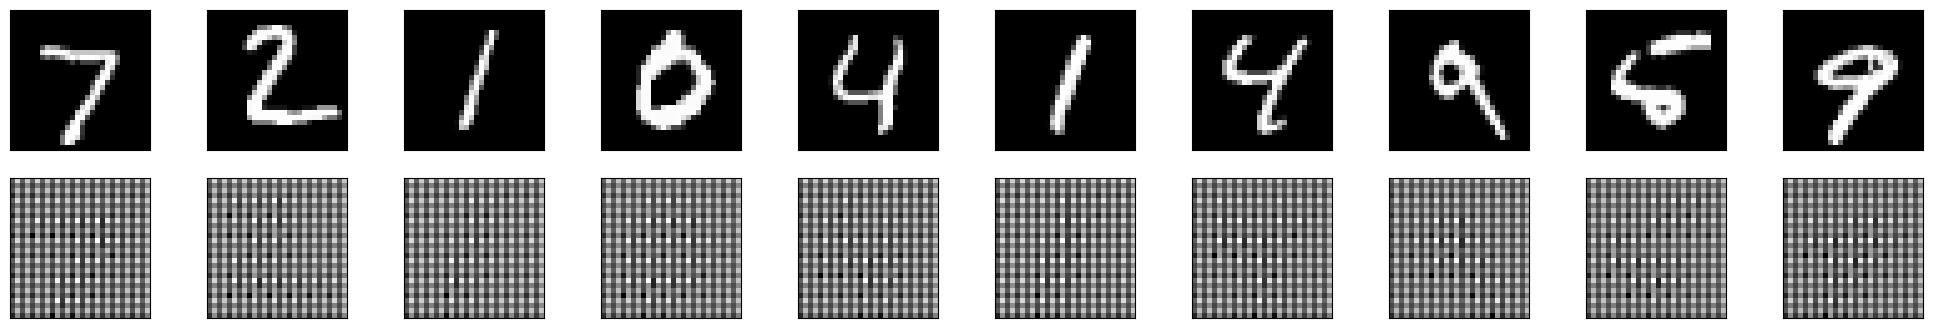

In [39]:
test(model_0,'conv')

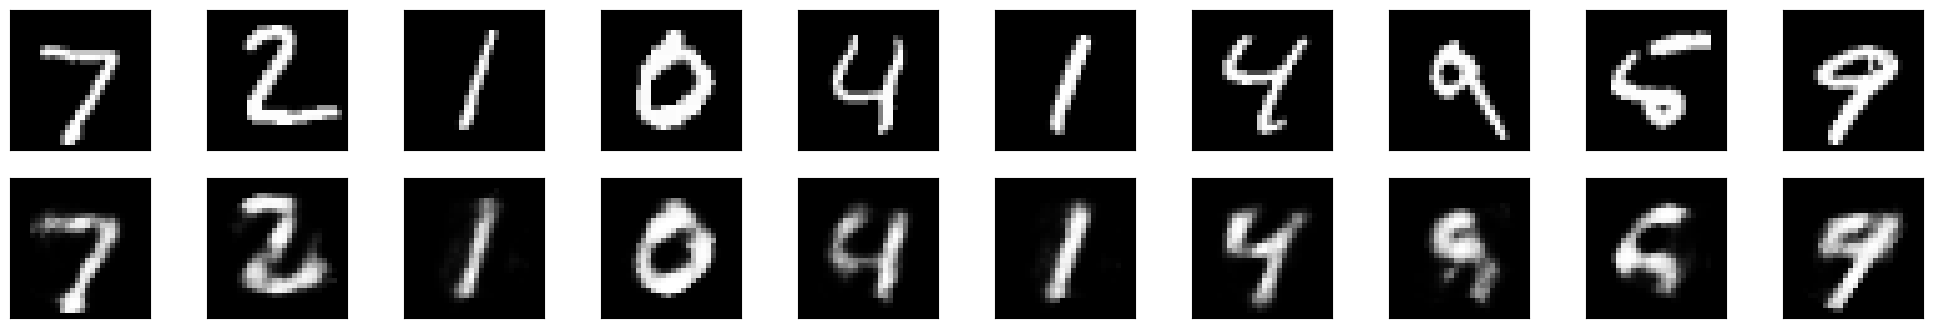

In [40]:
test(model_1)

## Transpose CNN Autoencoder

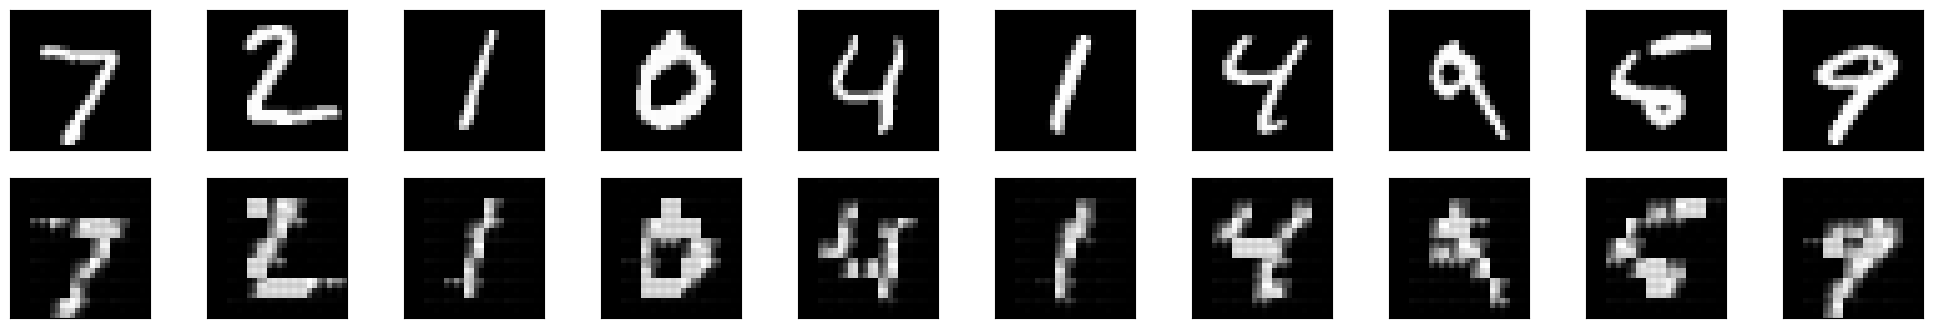

In [41]:
test(model_2,'conv')

## Upsampled CNN Autoencoder

/home/hillary/miniconda3/envs/opti/lib/python3.12/site-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


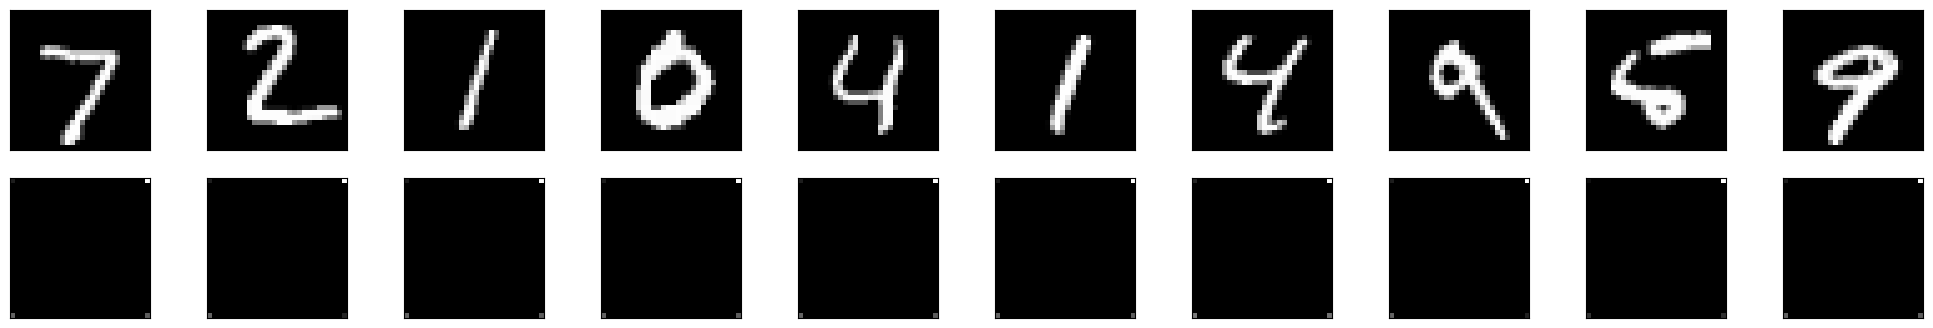

In [42]:
test(model_3,'conv')

## Visualize latent space

In [71]:
# Print Model Summary 
model = model_2

# Get Encoder Output of AutoEncoder Model
def get_encoder_output(model):
    model.eval()
    dataiter = iter(train_loader)
    images, labels = next(dataiter)
    if use_cuda and torch.cuda.is_available():
        images=images.cuda()
    output = model.encoder(images)
    return output,labels

In [99]:
def get_encoder_outputs(model, test_loader, max_batches=None):
    model.eval()
    encoded_images = []
    labels_list = []
    num_batches_processed = 0

    for images, labels in test_loader:
        if torch.cuda.is_available():
            images = images.cuda()

        # Encode images using the encoder part of the model
        with torch.no_grad():  # Ensure no gradients are calculated
            encoded_output = model.encoder(images)

        # Append the encoded images and corresponding labels to lists
        encoded_images.append(encoded_output.cpu())  # Store on CPU
        labels_list.append(labels)

        num_batches_processed += 1
        if max_batches is not None and num_batches_processed >= max_batches:
            break  # Stop processing after reaching the specified max_batches

    # Concatenate the lists to create tensors for encoded images and labels
    encoded_images = torch.cat(encoded_images, dim=0)
    labels_tensor = torch.cat(labels_list, dim=0)

    return encoded_images, labels_tensor


In [161]:
latents,labels=get_encoder_outputs(model,test_loader,max_batches=50)

### Visualize with PCA

In [164]:
def visualize_latent_space_pca(latents,labels):
    # Convert the 4D latent space to 2D using PCA
    pca = PCA(n_components=2)
    latents_2d = pca.fit_transform(latents.view(latents.size(0), -1).cpu().detach().numpy())

    # Create a DataFrame for easy plotting
    latent_df = pd.DataFrame(latents_2d, columns=['PC1', 'PC2'])
    latent_df['Label'] = labels.numpy()

    # Plot the 2D latent space
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=latent_df, x='PC1', y='PC2', hue='Label', palette='tab10')
    plt.title('2D PCA of Latent Space')
    plt.show()

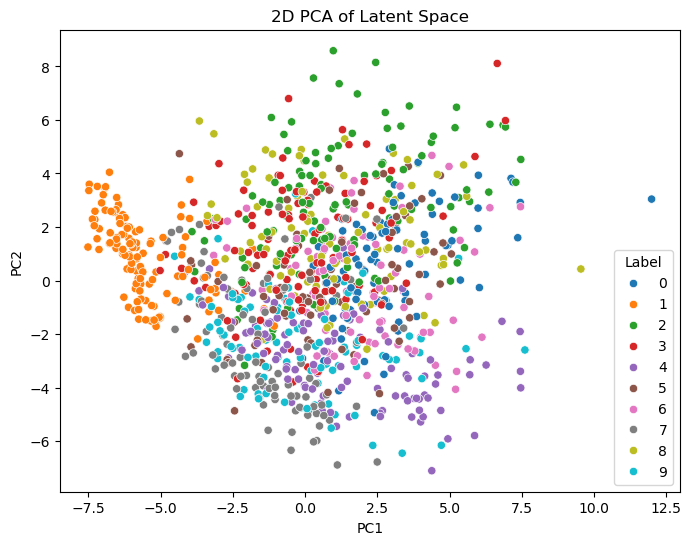

In [165]:
visualize_latent_space_pca(latents,labels)

### Visualise with t-SNE

In [112]:
#Visualize with tSne
latents_reshaped = latents.view(latents.shape[0], -1)  # Reshape to [20, 4*7*7]

# Convert to numpy array and apply PCA
latents_np = latents_reshaped.cpu().detach().numpy()
tsne = TSNE(n_components=2, random_state=1,perplexity=10)
latent_tsne = tsne.fit_transform(latents_np)

# Create a DataFrame for seaborn plotting
latent_df = pd.DataFrame(latent_tsne, columns=['Component 1', 'Component 2'])
latent_df['Label'] = labels#.detach().numpy().astype(str)

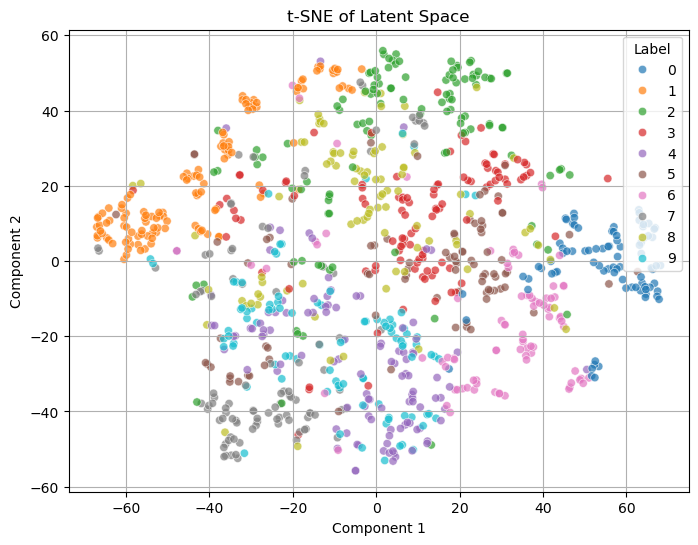

In [113]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=latent_df, x='Component 1', y='Component 2', hue='Label', palette='tab10', alpha=0.7)
plt.title('t-SNE of Latent Space')
plt.legend(title='Label', loc='upper right')
plt.grid(True)
plt.show()

## Choose Anchors

In [122]:
anchors = get_anchors(5,1)

Seed set to 1


In [128]:
from torch.utils.data import SubsetRandomSampler, DataLoader

# Define constants
batch_size = 5
num_workers = 0

# Total number of images in the training dataset
num_images = len(train_data)

# Generate random indices to select 5 random images
random_indices = np.random.choice(num_images, size=5, replace=False)

# Create a subset sampler using the random indices
random_subset_sampler = SubsetRandomSampler(random_indices)

# Create a data loader for the random subset
random_subset_loader = DataLoader(train_data,
                                  batch_size=batch_size,
                                  sampler=random_subset_sampler,
                                  num_workers=num_workers)


In [137]:
dataiter = iter(random_subset_loader)
anchors,anchors_labels = next(dataiter)
# Get encoding of anchors
for anchor in anchors:
    anchor_encoded = model.encoder(anchor.cuda())
    print(anchor_encoded.shape)

torch.Size([4, 7, 7])
torch.Size([4, 7, 7])
torch.Size([4, 7, 7])
torch.Size([4, 7, 7])
torch.Size([4, 7, 7])


In [139]:
anchors.shape

torch.Size([5, 1, 28, 28])

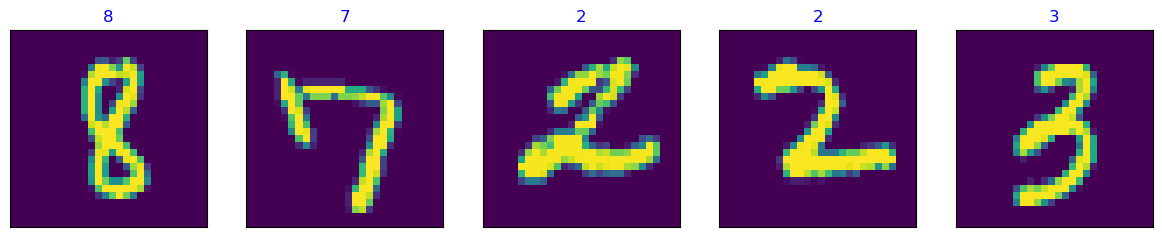

In [132]:
# Displaying the anchors
fig=plt.figure(figsize=(30,10))
for i in range(len(anchors_labels)):
    ax=fig.add_subplot(2,10,i+1,xticks=[],yticks=[])
    plt.imshow(np.squeeze(anchors[i]))
    ax.set_title(anchors_labels[i].item(),color='blue')

## Compute distance and similarity fucntion

In [168]:
from torch import cosine_similarity

In [218]:
def compute_similarity_image(model,anchors,image):
    image_similarities=[]
    image_encoded = model.encoder(image.cuda()).flatten().reshape(1, -1)
    for anchor in anchors:
        anchor_encoded = model.encoder(anchor.cuda()).flatten().reshape(1, -1)
        similarity = cosine_similarity(anchor_encoded, image_encoded)
        image_similarities.append(similarity.cpu().detach().numpy())
    return image_similarities

def get_similarities(model, data_loader, anchors, max_batches=None):
    model.eval()
    similarities_list=[]
    labels_list = []
    num_batches_processed = 0

    for images, labels in data_loader:
        if torch.cuda.is_available():
            images = images.cuda()

        #Append the computed similiarities for each iamge
        for image in images:
            image_similarities = compute_similarity_image(model,anchors,image)
            similarities_list.append(image_similarities)
        labels_list.append(labels)

        num_batches_processed += 1
        if max_batches is not None and num_batches_processed >= max_batches:
            break  # Stop processing after reaching the specified max_batches

    # Concatenate the lists to create tensors for encoded images and labels
    similarities  = torch.tensor(similarities_list)
    labels = torch.cat(labels_list, dim=0)

    return similarities, labels


In [216]:
similarities,labels = get_similarities(model,train_loader,anchors,10)

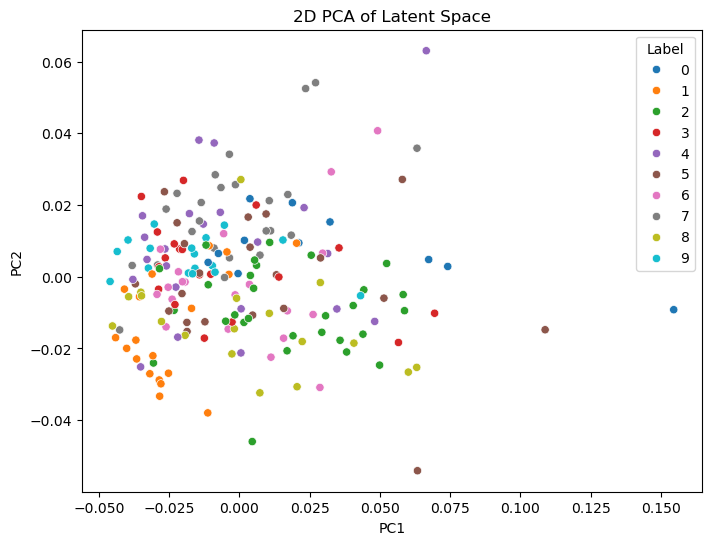

In [217]:
visualize_latent_space_pca(similarities,labels)